In [17]:
import numpy as np
import pandas as pd
import pydicom
import os
import plotly
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt

import time

In [18]:
INPUT_FOLDER = 'C:/Users/Poras/Desktop/osic-pulmonary-fibrosis-progression/train'

patients = os.listdir(INPUT_FOLDER)
patients.sort()

print("Some examples of patient IDs:")
print(",\n".join(patients[:10]))

Some examples of patient IDs:
ID00007637202177411956430,
ID00009637202177434476278,
ID00010637202177584971671,
ID00011637202177653955184,
ID00012637202177665765362,
ID00014637202177757139317,
ID00015637202177877247924,
ID00019637202178323708467,
ID00020637202178344345685,
ID00023637202179104603099


In [19]:
def load_scan(path):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [35]:
def get_pixels_hu(scans):
    """
    Converts raw images to Hounsfield Units (HU).
    
    Parameters: scans (Raw images)
    
    Returns: image (NumPy array)
    """
    
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)

    # Since the scanning equipment is cylindrical in nature and image output is square,
    # we set the out-of-scan pixels to 0
    image[image == -2000] = 0
    
    
    # HU = m*P + b
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [55]:

test_patient_scans = load_scan(INPUT_FOLDER + '/'+ patients[24])
test_patient_images = get_pixels_hu(test_patient_scans)

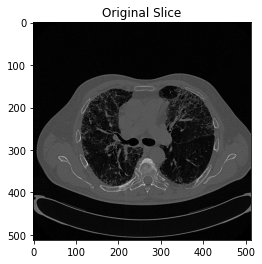

In [56]:
plt.imshow(test_patient_images[12], cmap='gray')
plt.title("Original Slice")
plt.show()

In [53]:
def generate_markers(image):
    """
    Generates markers for a given image.
    
    Parameters: image
    
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

In [54]:
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[12])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

ax1.imshow(test_patient_internal, cmap='gray')
ax1.set_title("Internal Marker")
ax1.axis('off')

ax2.imshow(test_patient_external, cmap='gray')
ax2.set_title("External Marker")
ax2.axis('off')

ax3.imshow(test_patient_watershed, cmap='gray')
ax3.set_title("Watershed Marker")
ax3.axis('off')

plt.show()

ValueError: operands could not be broadcast together with shapes (512,512) (768,768) (512,512) 

In [ ]:
# Lists to store computation times and iterations
computation_times = []
iteration_titles = []

In [ ]:
def seperate_lungs(image, iterations = 1):
    """
    Segments lungs using various techniques.
    
    Parameters: image (Scan image), iterations (more iterations, more accurate mask)
    
    Returns: 
        - Segmented Lung
        - Lung Filter
        - Outline Lung
        - Watershed Lung
        - Sobel Gradient
    """
    
    # Store the start time
    start = time.time()
    
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    
    '''
    Creation of Sobel Gradient
    '''
    
    # Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    
    '''
    Using the watershed algorithm
    
    
    We pass the image convoluted by sobel operator and the watershed marker
    to morphology.watershed and get a matrix matrix labeled using the 
    watershed segmentation algorithm.
    '''
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    '''
    Reducing the image to outlines after Watershed algorithm
    '''
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    
    '''
    Black Top-hat Morphology:
    
    The black top hat of an image is defined as its morphological closing
    minus the original image. This operation returns the dark spots of the
    image that are smaller than the structuring element. Note that dark 
    spots in the original image are bright spots after the black top hat.
    '''
    
    # Structuring element used for the filter
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations)
    
    # Perform Black Top-hat filter
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    '''
    Generate lung filter using internal marker and outline.
    '''
    lungfilter = np.bitwise_or(marker_internal, outline)
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    '''
    Segment lung using lungfilter and the image.
    '''
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    # Append computation time
    end = time.time()
    computation_times.append(end - start)
    iteration_titles.append("{num} iterations".format(num = iterations))
    
    
    return segmented, lungfilter, outline, watershed, sobel_gradient

In [ ]:
for itrs in range(1, 9):
    test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient = seperate_lungs(test_patient_images[12], itrs)

In [ ]:
itr_dict = {'Iterations' : iteration_titles, 'Computation Times (in seconds)': computation_times}

colors = ['#30336b',] * 8
colors[0] = '#eb4d4b'

import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure(data=[go.Bar(
    x=itr_dict['Iterations'],
    y=itr_dict['Computation Times (in seconds)'],
    marker_color = colors
)])
fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')


fig.update_layout(
    title = 'Iterations vs Computation Times',
    yaxis=dict(
        title='Computation Times (in seconds)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    autosize=False,
    width=800,
    height=800)

fig.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12, 12))

ax1.imshow(test_sobel_gradient, cmap='gray')
ax1.set_title("Sobel Gradient")
ax1.axis('off')

ax2.imshow(test_watershed, cmap='gray')
ax2.set_title("Watershed")
ax2.axis('off')

plt.show()

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (12, 12))

ax1.imshow(test_outline, cmap='gray')
ax1.set_title("Lung Outline")
ax1.axis('off')

ax2.imshow(test_lungfilter, cmap='gray')
ax2.set_title("Lung filter")
ax2.axis('off')

ax3.imshow(test_segmented, cmap='gray')
ax3.set_title("Segmented Lung")
ax3.axis('off')

plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12, 12))

ax1.imshow(test_patient_images[12], cmap='gray')
ax1.set_title("Original Lung")
ax1.axis('off')

ax2.imshow(test_segmented, cmap='gray')
ax2.set_title("Segmented Lung")
ax2.axis('off')

plt.show()